In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize 
from datetime import datetime as dt
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols
from scipy.stats import norm
from scipy.optimize import minimize_scalar   
import pandas as pd
import datetime as dt
import scipy.integrate
import cmath
import scipy.integrate as spi
import math
import yfinance as yf
import pandas as pd
from datetime import datetime as dt
from pandas.tseries.offsets import BDay
import matplotlib.markers as mk
import matplotlib.ticker as mtick
import time

In [7]:
def phi(u, S0, K, tau, r,d, v0, theta, rho, kappa, sigma):
    alpha_hat = -0.5 * u * (u + 1j)
    beta = kappa - 1j * u * sigma * rho
    gamma = 0.5 * sigma ** 2
    D = np.sqrt(beta**2 - 4 * alpha_hat * gamma)
    g = (beta - D) / (beta + D)
    h = np.exp(-D*tau)
    A_ = (beta-D)*tau - 2*np.log((g*h-1) / (g-1))
    A = kappa * theta / (sigma**2) * A_
    B = (beta - D) / (sigma**2) * (1 - h) / (1 - g*h)
    return np.exp(A + B * v0)
def H_callacc(S0, K, tau, r,d, v0, theta, rho, kappa, sigma,lambd):
    a = np.log(S0/K) + (r-d)*tau
    integrand = (lambda u: 
        np.real(np.exp((1j*u + 0.5)*a)*phi(u - 0.5j, S0, K, tau, r,d, v0, theta, rho, kappa, sigma))/(u**2 + 0.25))

    i, err = scipy.integrate.quad_vec(integrand, 0, float('inf'))
    return S0 * np.exp(-d*tau) - K * np.exp(-r*tau)/np.pi*i
def H_callsingle(S0, K, tau, r,d, v0, theta, rho, kappa, sigma,lambd):
    a = np.log(S0/K) + (r-d)*tau
    integrand = (lambda u: 
        np.real(np.exp((1j*u + 0.5)*a)*phi(u - 0.5j, S0, K, tau, r,d, v0, theta, rho, kappa, sigma))/(u**2 + 0.25))

    i, err = scipy.integrate.quad_vec(integrand, 0, float('inf'))
    return S0 * np.exp(-d*tau) - K * np.exp(-r*tau)/np.pi*i
def H_call(S0, K, tau, r,d, v0, theta, rho, kappa, sigma,lambd):
    a = np.log(S0/K) + (r-d)*tau
    i = []
    c=0
    while len(K)>c:
        res, err = scipy.integrate.quad_vec(lambda u: np.real(np.exp((1j*u + 0.5)*a[c])*phi(u - 0.5j, S0, K[c], tau[c], r[c],d, v0, theta, rho, kappa, sigma))/(u**2 + 0.25), 0, 200,epsrel = 5.49e-1)
        i.append(res)
        c = c+1
    return S0 * np.exp(-d*tau) - K * np.exp(-r*tau)/np.pi*i       
print(H_callsingle(100, 100, 0.03, 0.2,0, 0.04, 0.04, -0.7, 3, 0.3,0),call_heston_cfsingle1(100, 100, 0.03, 0.2,0, 0.04, 0.04, -0.7, 3, 0.3,0),call_heston_cfsingle(81, 100.2, 1.1, 0.2,0, 0.04, 0.04, -0.7, 3, 0.3,0))
                                                                                            

1.7036644327204584 2.0316674341576118 6.771388252703218


In [6]:
def call_heston_cf(S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
 
    if sigma < 0.001:
        sigma = 0.001
    
    def P1(om, S, X, tau, r, q, v0, vT, rho, k, sigma, lambd):
        p = np.exp(-1j * np.log(X) * om) * cf_heston(om - 1j, S, tau, r, q, v0, vT, rho, k, sigma,lambd) / (1j * om * S * np.exp((r - q) * tau))
        return p.real
    
    def P2(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
        p = np.exp(-1j * np.log(X) * om) * cf_heston(om, S, tau, r, q, v0, vT, rho, k, sigma,lambd) / (1j * om)
        return p.real
    
    def cf_heston(om, S, tau, r, q, v0, vT, rho, k, sigma,lambd):
        a = k*vT
        b = k + lambd
    
        d = np.sqrt((rho * sigma * 1j * om - b)**2 + sigma**2 *
                    (1j * om + om**2))
        g = (b - rho * sigma * 1j * om - d) / (b - rho * sigma * 1j * om + d)
        cf1 = 1j * om * (np.log(S) + (r - q) * tau)
        cf2 = (a * tau)/ (sigma**2) * ((b - rho * sigma * 1j * om - d)  - 2 * np.log((1 - g * np.exp(-d * tau)) / (1 - g)))
        cf3 = v0 / sigma**2 * (b - rho * sigma * 1j * om - d) * (1 - np.exp(-d * tau)) / (1 - g * np.exp(-d * tau))
        return np.exp(cf1 + cf2 + cf3)
    #if len(X)>1:
    c=0
    result = []
    vP1 = []
    vP2 = []
    tol = (X/S)**5/3**r
    tol[tol< 0.2] = 0.2
    tol[tol> 10] = 10
    while len(X)>c:
        vP1= 0.5 + 1/np.pi * spi.quad(lambda om: P1(om, S, X[c], tau[c], r[c], q, v0, vT, rho, k, sigma,lambd), 0, 80,epsrel = (1.09e-1)/tol[c])[0]
        vP2= 0.5 + 1/np.pi * spi.quad(lambda om: P2(om, S, X[c], tau[c], r[c], q, v0, vT, rho, k, sigma,lambd), 0, 80,epsrel = (1.09e-1)/tol[c])[0]
        res = (np.exp(-q * tau[c]) * S * vP1 - np.exp(-r[c] * tau[c]) * X[c] * vP2).real
        result.append(res)
        c = c+1
    #else:
        #vP1 = 0.5 + 1/np.pi * spi.quad(lambda om: P1(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd), 0, float('inf'))[0]
        #vP2 = 0.5 + 1/np.pi * spi.quad(lambda om: P2(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd), 0, float('inf'))[0]
   
    #result = (np.exp(-q * tau) * S * vP1 - np.exp(-r * tau) * X * vP2).real

    return result
def call_heston_cfsingle(S, X: np.array, tau, r, q, v0, vT, rho, k, sigma,lambd):
 
    if sigma < 0.001:
        sigma = 0.001
    
    def P1(om, S, X, tau, r, q, v0, vT, rho, k, sigma, lambd):
        p = np.exp(-1j * np.log(X) * om) * cf_heston(om - 1j, S, tau, r, q, v0, vT, rho, k, sigma,lambd) / (1j * om * S * np.exp((r - q) * tau))
        return p.real
    
    def P2(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
        p = np.exp(-1j * np.log(X) * om) * cf_heston(om, S, tau, r, q, v0, vT, rho, k, sigma,lambd) / (1j * om)
        return p.real
    
    def cf_heston(om, S, tau, r, q, v0, vT, rho, k, sigma,lambd):
        a = k*vT
        b = k + lambd
    
        d = np.sqrt((rho * sigma * 1j * om - b)**2 + sigma**2 *
                    (1j * om + om**2))
        g = (b - rho * sigma * 1j * om - d) / (b - rho * sigma * 1j * om + d)
        cf1 = 1j * om * (np.log(S) + (r - q) * tau)
        cf2 = (a * tau)/ (sigma**2) * ((b - rho * sigma * 1j * om - d)  - 2 * np.log((1 - g * np.exp(-d * tau)) / (1 - g)))
        cf3 = v0 / sigma**2 * (b - rho * sigma * 1j * om - d) * (1 - np.exp(-d * tau)) / (1 - g * np.exp(-d * tau))
        return np.exp(cf1 + cf2 + cf3)
    
    vP1 = 0.5 + 1/np.pi * spi.quad(lambda om: P1(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd), 0, 80,epsrel = 1.49e-1)[0]
    vP2 = 0.5 + 1/np.pi * spi.quad(lambda om: P2(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd), 0, 80,epsrel = 1.49e-1)[0]
    result = np.exp(-q * tau) * S * vP1 - np.exp(-r * tau) * X * vP2
    return result.real
def call_heston_cfsingle1(S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
 
    if sigma < 0.001:
        sigma = 0.001
    
    def P1(om, S, X, tau, r, q, v0, vT, rho, k, sigma, lambd):
        p = np.exp(-1j * np.log(X) * om) * cf_heston(om - 1j, S, tau, r, q, v0, vT, rho, k, sigma,lambd) / (1j * om * S * np.exp((r - q) * tau))
        return p.real
    
    def P2(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
        p = np.exp(-1j * np.log(X) * om) * cf_heston(om, S, tau, r, q, v0, vT, rho, k, sigma,lambd) / (1j * om)
        return p.real
    
    def cf_heston(om, S, tau, r, q, v0, vT, rho, k, sigma,lambd):
        a = k*vT
        b = k + lambd
    
        d = np.sqrt((rho * sigma * 1j * om - b)**2 + sigma**2 *
                    (1j * om + om**2))
        g = (b - rho * sigma * 1j * om - d) / (b - rho * sigma * 1j * om + d)
        cf1 = 1j * om * (np.log(S) + (r - q) * tau)
        cf2 = (a * tau)/ (sigma**2) * ((b - rho * sigma * 1j * om - d)  - 2 * np.log((1 - g * np.exp(-d * tau)) / (1 - g)))
        cf3 = v0 / sigma**2 * (b - rho * sigma * 1j * om - d) * (1 - np.exp(-d * tau)) / (1 - g * np.exp(-d * tau))
        return np.exp(cf1 + cf2 + cf3)
    
    vP1 = 0.5 + 1/np.pi * spi.quad(lambda om: P1(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd), 0, float('inf'))[0]
    vP2 = 0.5 + 1/np.pi * spi.quad(lambda om: P2(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd), 0, float('inf'))[0]
    result = np.exp(-q * tau) * S * vP1 - np.exp(-r * tau) * X * vP2
    if result < 0:
        result = 0
    return result
def call_heston_cf1(S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
    
    if sigma < 0.001:
        sigma = 0.001
    def P1(om, S, X, tau, r, q, v0, vT, rho, k, sigma, lambd):
        p = np.exp(-1j * np.log(X) * om) * cf_heston(om - 1j, S, tau, r, q, v0, vT, rho, k, sigma,lambd) / (1j * om * S * np.exp((r - q) * tau))
        return p.real
    
    def P2(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
        p = np.exp(-1j * np.log(X) * om) * cf_heston(om, S, tau, r, q, v0, vT, rho, k, sigma,lambd) / (1j * om)
        return p.real
    
    def cf_heston(om, S, tau, r, q, v0, vT, rho, k, sigma,lambd):
        a = k*vT
        b = k + lambd
    
        d = np.sqrt((rho * sigma * 1j * om - b)**2 + sigma**2 *
                    (1j * om + om**2))
        g = (b - rho * sigma * 1j * om - d) / (b - rho * sigma * 1j * om + d)
        cf1 = 1j * om * (np.log(S) + (r - q) * tau)
        cf2 = (a * tau)/ (sigma**2) * ((b - rho * sigma * 1j * om - d)  - 2 * np.log((1 - g * np.exp(-d * tau)) / (1 - g)))
        cf3 = v0 / sigma**2 * (b - rho * sigma * 1j * om - d) * (1 - np.exp(-d * tau)) / (1 - g * np.exp(-d * tau))
        return np.exp(cf1 + cf2 + cf3)
    om = np.linspace(0.01, 100.01, num=100000)
    vP1 = 0.5 + 1/np.pi * np.trapz(P1(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd), x = om)
    vP2 = 0.5 + 1/np.pi * np.trapz(P2(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd), x = om)
    result = np.exp(-q * tau) * S * vP1 - np.exp(-r * tau) * X * vP2

    return result.real

def call_heston_cfrec(S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
    
    if sigma < 0.001:
        sigma = 0.001
    #@njit(float64[:](float64[:]),[float64(float64), float64[:](float64[:]),float64[:](float64[:]),float64[:](float64[:]),float64(float64),float64(float64),float64(float64),float64(float64),float64(float64),float64(float64),float64(float64)])
    
    def P1(om, S, X, tau, r, q, v0, vT, rho, k, sigma, lambd):
        p = np.exp(-1j * np.log(X) * om) * cf_heston(om - 1j, S, tau, r, q, v0, vT, rho, k, sigma,lambd) / (1j * om * S * np.exp((r - q) * tau))
        return p.real
    
    def P2(om, S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
        p = np.exp(-1j * np.log(X) * om) * cf_heston(om, S, tau, r, q, v0, vT, rho, k, sigma,lambd) / (1j * om)
        return p.real
    
    def cf_heston(om, S, tau, r, q, v0, vT, rho, k, sigma,lambd):
        a = k*vT
        b = k + lambd
    
        d = np.sqrt((rho * sigma * 1j * om - b)**2 + sigma**2 *
                    (1j * om + om**2))
        g = (b - rho * sigma * 1j * om - d) / (b - rho * sigma * 1j * om + d)
        cf1 = 1j * om * (np.log(S) + (r - q) * tau)
        cf2 = (a * tau)/ (sigma**2) * ((b - rho * sigma * 1j * om - d)  - 2 * np.log((1 - g * np.exp(-d * tau)) / (1 - g)))
        cf3 = v0 / sigma**2 * (b - rho * sigma * 1j * om - d) * (1 - np.exp(-d * tau)) / (1 - g * np.exp(-d * tau))
        return np.exp(cf1 + cf2 + cf3)
    
    
    def recint1(S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
        args = (S, X, tau, r, q, v0, vT, rho, k, sigma,lambd)
    
        P, umax, N = 0, 100, 1000
        dphi=umax/N
        for i in range(1,N):
           
           phi = dphi * (2*i + 1)/2 
           numerator = P1(phi,*args)
           P += dphi * numerator
        return P
    
       
    def recint2(S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
        args = (S, X, tau, r, q, v0, vT, rho, k, sigma,lambd)
    
        P, umax, N = 0, 100, 1000
        dphi=umax/N 
        for i in range(1,N):
           
           phi = dphi * (2*i + 1)/2 
           numerator = P2(phi,*args)
           P += dphi * numerator
        return P
    
    vP1 = 0.5 + 1/np.pi * recint1(S, X, tau, r, q, v0, vT, rho, k, sigma,lambd)
    vP2 = 0.5 + 1/np.pi * recint2(S, X, tau, r, q, v0, vT, rho, k, sigma,lambd)
    result = np.exp(-q * tau) * S * vP1 - np.exp(-r * tau) * X * vP2
    print("1")
    return result.real

def put_heston_cf(S, X, tau, r, q, v0, vT, rho, k, sigma,lambd):
    c = call_heston_cf(S, X, tau, r, q, v0, vT, rho, k, sigma,lambd)
    return X*np.exp(-r*tau)+c-S


In [8]:

N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    
    
def implied_vol(opt_value, S, K, T, r, type_='call'):
    
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    
    def put_obj(sigma):
        return abs(BS_PUT(S, K, T, r, sigma) - opt_value)
    
    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,20), method='bounded')
        return res.x
    elif type_ == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01,20),
                              method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")
def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    historical_prices = ticker.history(period='1d', interval='1m')
    price = historical_prices['Close'].iloc[-1]
    print(price)
    return price

yield_maturities = np.array([3/12, 5,10, 30])
yields = np.array([get_current_price("^IRX"),get_current_price("^FVX"),get_current_price("^TNX"),get_current_price("^TYX")]).astype(float)/100
curve_fit, status = calibrate_nss_ols(yield_maturities,yields)

def getcalls1(tick, threshold, Tcutoff):
   SPY = yf.Ticker(tick)
   expiration_dates = list(SPY.options)
   nexp = len(expiration_dates)
   i = 0
   SPYtot = pd.DataFrame({'strike': [0], 'today': [0]})
   while i < nexp:
      SPYopt1 = SPY.option_chain(expiration_dates[i]).calls.iloc[0:2000,2:11]
      SPYopt1.insert(1, "T", ((dt.strptime(expiration_dates[i], '%Y-%m-%d') - (dt.today() - BDay(1))).days)/365.25, True)
      if i == 0:
        SPYtot = SPYopt1
      else:
        SPYtot = pd.concat([SPYtot, SPYopt1], ignore_index=True)
      i= i+1
   bidask = SPYtot.iloc[0:10000,3:5]
   price = bidask[["bid","ask"]].sum(axis=1)/2
   SPYtot.insert(3, "Price", price, True)
   SPYtot = SPYtot.drop(["lastPrice","bid","ask","change","percentChange", "openInterest"], axis=1)
   SPYtot=SPYtot.dropna(thresh = len(SPYtot.columns))
   SPYtot = SPYtot[SPYtot["volume"] >= threshold]
   SPYtot = SPYtot[SPYtot["impliedVolatility"] >= 0.01]
   SPYtot = SPYtot[SPYtot["T"] >= Tcutoff]
   strikes = SPYtot["strike"].to_numpy()
   maturities = SPYtot["T"].to_numpy()
   prices = SPYtot["Price"].to_numpy()
   volumes = SPYtot["volume"].to_numpy()
   vol = SPYtot["impliedVolatility"].to_numpy()
   return strikes, maturities, prices, volumes, vol

def getcalls(tick, threshold):
   SPY = yf.Ticker(tick)
   expiration_dates = list(SPY.options)
   nexp = len(expiration_dates)
   i = 0
   SPYtot = pd.DataFrame({'strike': [0], 'today': [0]})
   while i < nexp:
      SPYopt1 = SPY.option_chain(expiration_dates[i]).calls.iloc[0:2000,2:3]
      bidask = SPY.option_chain(expiration_dates[i]).calls.iloc[0:2000,4:6]
      price = bidask[["bid","ask"]].sum(axis=1)/2
      SPYopt1.insert(1,expiration_dates[i],price)
      if i == 0:
        SPYtot = SPYopt1
      else:
        SPYtot=pd.merge(SPYopt1, SPYtot, on='strike', how='outer', sort = "true")
      i= i+1
   SPYtot = SPYtot.dropna(axis='columns', thresh=len(SPYtot)/threshold)
   SPYtot=SPYtot.dropna(thresh = len(SPYtot.columns))
   SPYtot = SPYtot.reindex(sorted(SPYtot.columns), axis=1)
   first_column = SPYtot.pop('strike')
   SPYtot.insert(0, 'strike', first_column)
   SPYtot = SPYtot.reset_index(drop=True)
   SPYtot = SPYtot.drop(SPYtot.columns[1], axis = 1)
   SPYtot = SPYtot.drop(SPYtot.columns[1], axis = 1)
   SPYtot = SPYtot.drop(SPYtot.columns[1], axis = 1)
   #threshold = 0.025
   #for column in SPYtot.columns:
    #SPYtot = SPYtot[SPYtot[column] >= threshold]
    
   prices = []
   maturities = []
   strikes = []
   volumeslist =[]
   i = 1
   j = 0
   print(SPYtot)
   while i < len(SPYtot.columns):
     maturities.append(((dt.strptime(SPYtot.columns[i], '%Y-%m-%d') - (dt.today() - BDay(1))).days)/365.25)
     price = []
     volumes = []
     volume = SPY.option_chain(SPYtot.columns[i]).calls.iloc[0:2000,2:3]
     values = SPY.option_chain(SPYtot.columns[i]).calls.iloc[0:2000,8:9]
     values = values.fillna(0)
     volume.insert(1,'volume',values)
     j = 0
     while j < len(SPYtot):
      price.append(SPYtot.iloc[j,i])
      volume1 = volume.loc[volume['strike'] == SPYtot.iloc[j,0]]
      volumes.append(volume1.iloc[0,1])
      if i == 1:
       strikes.append(SPYtot.iloc[j,0])
      j = j + 1
     prices.append(price)
     price_arr = np.array(prices, dtype=object)
     np.shape(price_arr)
     volumeslist.append(volumes)
     volume_arr = np.array(volumeslist, dtype=object)
     np.shape(volume_arr)
     i= i +1
   return strikes, price_arr, maturities, volume_arr
d = 0

def Heston_calibration(ticker,uselambda,mode,treshold,accuracy,allcalls,**kwargs):
    #Ticker: Ticker in Yahoo Finance of the stock
    #UseLambda: If True the parameter lambda will be used in the calibration
    #Mode: 1 For implied volatility calibration; 2 For Price calibration (Recommended); 3 For Implied volatility and Price calibration. Default is 2
    #Treshold: 1/Treshold is the minimum amount of available prices accepted for a maturity given the full list of strikes from all maturities,
    #only available if AllCalls is set to FALSE. Recommended vaues from 3 to 5
    #Accuracy: The calibration precision, 1e-5 yields accurate results, going lower can slow down the calibration without significant improvements
    #AllCalls: If TRUE the calibration will be performed on all alavilable calls with valid prices and volatilities and with volume higher then MinVolume
    #MinVolume: OPTIONAL Minimum volume allowed for a strike and maturity pair. Only if AllCalls is set to TRUE. Defaut is 1
    #Price: OPTIONAL If given sets the initial stock price. Useful for After Hour prices or if forward prices need to be used for better results
    #DivYield: OPTIONAL If given sets the dividend yield
    #Tcutoff: OPTIONAL Only if AllCalls is set to TRUE, discards maturities lower then the value given (in years: 1 = 1 Year)
    #Leverage: OPTIONAL Sets the leverage for the initial parameters of the calibration, can speed up the calibration. Default is 1
    
    Givenprice = kwargs.get('Price', None)
    Givenyield = kwargs.get('DivYield', None)
    Tcutoff = kwargs.get('Tcutoff', None)
    l = kwargs.get('Leverage', None)
    MinVolume = kwargs.get('MinVolume', None)
    if l == None:
        l = 1
    if Tcutoff == None:
        Tcutoff = 0
    if MinVolume == None:
        MinVolume = 1
    if mode ==1:
        factor = 0.1
    elif mode ==2:
        factor = 1
    elif mode ==3:
        factor = 2
    else:
        mode = 2
        factor = 1
    if uselambda == 'TRUE':
     lam = 1
    else:
     lam = 0
    if allcalls == "FALSE":
     common_strikes, price_arr, maturities, volume_arr = getcalls(ticker,treshold)
     volSurfacevol = pd.DataFrame(volume_arr, index = maturities, columns = common_strikes)
     volSurfacevolLong = volSurfacevol.melt(ignore_index=False).reset_index()
     volSurfacevolLong.columns = ['maturity', 'strike', 'volume']
     volSurface = pd.DataFrame(price_arr, index = maturities, columns = common_strikes)
     volSurfaceLong = volSurface.melt(ignore_index=False).reset_index()
     volSurfaceLong.columns = ['maturity', 'strike', 'price']
     volSurfaceLong['volume'] = volSurfacevolLong['volume']
    else:
     strikes, maturities, prices, volumes, vol = getcalls1(ticker,MinVolume,Tcutoff)
     volSurfaceLong = pd.DataFrame({'strike': strikes, 'maturity': maturities, 'price': prices, 'volume': volumes,'IVY': vol})
        
    volSurfaceLong['rate'] = volSurfaceLong['maturity'].apply(curve_fit)
    if Givenprice == None:
     S0 = get_current_price(ticker)
    else:
        S0 = Givenprice
    print(S0)
    if Givenyield == None:
     try:
      TICK = yf.Ticker(ticker)
      d = TICK.info['dividendRate']/100
     except:
      d = 0
    else:
        d = Givenyield
    print(d,Givenyield)
    c = 0
    r = volSurfaceLong['rate'].to_numpy('float')
    K = volSurfaceLong['strike'].to_numpy('float')
    tau = volSurfaceLong['maturity'].to_numpy('float')
    P = volSurfaceLong['price'].to_numpy('float')
    v = volSurfaceLong['volume'].to_numpy('float')
    w = (v*P/np.sum(v*P))*len(P)
    iv = []
    while c <len(volSurfaceLong):
     iv.append(implied_vol(P[c], S0, K[c], tau[c], r[c]))
     c=c+1
    volSurfaceLong['IV'] = iv
    iv = volSurfaceLong['IV'].to_numpy('float')
    print(np.sum(volSurfaceLong['price']/len(volSurfaceLong['price']))/S0)
    print(volSurfaceLong.to_string())
    params = {"v0": {"x0": 0.03*l, "lbub": [-1,1]}, 
              "kappa": {"x0": 2.7, "lbub": [1e-3,5]},
              "theta": {"x0": 0.05*l**2, "lbub": [1e-3,2]},
              "sigma": {"x0": 0.8*l, "lbub": [1e-2,4]},
              "rho": {"x0": -0.7, "lbub": [-1,0]},
              "lambd": {"x0": 0.8, "lbub": [lam,lam*-1]},
              }
    x0 = [param["x0"] for key, param in params.items()]
    bnds = [param["lbub"] for key, param in params.items()]
    def SqErr(x):
        v0, kappa, theta, sigma, rho, lambd = [param for param in x]
        start_time = time.time()
        sum = 0
        count = 0
        c = 0
        ivh = []
        PH = H_call(S0, K, tau, r, d, v0, theta, rho,kappa,sigma, lambd)
        if mode == 1 or mode ==3:
         while c <len(volSurfaceLong):
            ivh.append(implied_vol(PH[c], S0, K[c], tau[c], r[c]))
            c = c+1
         ivh = np.array(ivh)
         errvol = np.sum(((iv-ivh)**2  /len(P))*w)
        if mode == 2 or mode ==3:
         err = np.sum(((P-PH)**2  /len(P))*w)/np.sum(P/len(P))
        if mode == 1:
            optval = errvol
            print(v0, kappa, theta, sigma, rho, lambd,optval)
        elif mode == 2:
            optval = err
            print(v0, kappa, theta, sigma, rho, lambd,optval)
        elif mode == 3:
            optval = err/np.average(P) * errvol *100
            print(v0, kappa, theta, sigma, rho, lambd, err,errvol,optval)
        pen = 0
        #pen = (np.sum( [(x_i/x0_i-x0_i/x0_i)**2 for x_i, x0_i in zip(x, x0)] ))*0.1
        print("--- %s seconds ---" % (time.time() - start_time))
        return optval

    result = minimize(SqErr, x0, tol = accuracy*factor, method='SLSQP', options={'maxiter': 1e3 }, bounds=bnds)
    v0, kappa, theta, sigma, rho, lambd = [param for param in result.x]
    print('V0',v0,'Kappa',kappa, 'Theta',theta, 'Sigma',sigma,'Rho', rho,'Lambda', lambd)
    heston_prices = H_call(S0, K, tau, r,d, v0, theta, rho, kappa, sigma, lambd)
    c = 0
    ivh= []
    iv= []
    heston2= []
    while c <len(volSurfaceLong):
            ivh.append(implied_vol(heston_prices[c], S0, K[c], tau[c], r[c]))
            heston2.append(H_callacc(S0, K[c], tau[c], r[c],d, v0, theta, rho, kappa, sigma, lambd))
            iv.append(implied_vol(heston2[c], S0, K[c], tau[c], r[c]))
            c = c+1
    ivh = np.array(ivh)
    iv = np.array(iv)
    volSurfaceLong['Weights'] = w
    volSurfaceLong['IVCal'] = ivh
    volSurfaceLong['IVH'] = iv
    volSurfaceLong['heston_price'] = heston_prices
    volSurfaceLong['heston_priceAcc'] = heston2
    volSurfaceLong['error'] = volSurfaceLong['heston_priceAcc']-volSurfaceLong['price']
    volSurfaceLong['square_error'] = volSurfaceLong['error']**2
    print(np.sum(volSurfaceLong['square_error'])/ len(volSurfaceLong))
    print(volSurfaceLong)
    return(volSurfaceLong, v0, kappa, theta, sigma, rho, lambd, S0)
    

5.240000247955322
4.306000232696533
4.289000034332275
4.440999984741211


In [ ]:
volSurfaceLong, v0, kappa, theta, sigma, rho, lambd, S0 = Heston_calibration("UPRO",'FALSE',2,3,1e-5,"TRUE", Price = None, DivYield = None, Tcutoff = 0.05, Leverage = None, MinVolume = 1)
print(volSurfaceLong.to_string())
c = 0
tau = volSurfaceLong['maturity']
tau = list(set(tau))
tau.sort()
while c <len(tau):
  plt.figure(dpi = 1200)
  plt.figure(figsize=(6,6))
  volSurfaceLong1= volSurfaceLong.loc[volSurfaceLong['maturity'] == tau[c]]
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.IV, color='black')
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.IVCal, color='green',linestyle="dotted")
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.IVH, color='black',linestyle="dashed")
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.IVY, color='blue',linestyle="dotted")
  plt.legend(['IV Real-World Prices', 'IV Heston Prices'], loc='upper right')
  plt.grid()
  plt.title("CALL (T = "+str(math.ceil(tau[c]*365.25))+" days)")
  plt.show()
  c = c + 1

73.02999877929688
73.02999877929688
0 None
0.20819296093810924
     strike  maturity   price  volume       IVY      rate        IV
0      50.0  0.062971  23.050     2.0  0.625004  0.053482  0.193847
1      58.0  0.062971  15.300     1.0  0.592778  0.053482  0.477326
2      63.0  0.062971  10.800     1.0  0.562993  0.053482  0.525442
3      64.0  0.062971   9.550     1.0  0.831545  0.053482  0.408556
4      65.0  0.062971   8.500     3.0  0.795412  0.053482  0.354469
5      66.5  0.062971   7.450     3.0  0.582524  0.053482  0.417387
6      67.0  0.062971   7.050     1.0  0.671634  0.053482  0.417009
7      67.5  0.062971   6.500     1.0  0.613041  0.053482  0.384744
8      68.0  0.062971   6.000     3.0  0.663089  0.053482  0.362763
9      68.5  0.062971   5.100     1.0  0.543950  0.053482  0.255022
10     69.0  0.062971   5.950     1.0  0.621342  0.053482  0.479860
11     69.5  0.062971   5.450     4.0  0.577885  0.053482  0.453100
12     70.0  0.062971   5.200    46.0  0.605961  0.05

8


<Figure size 7680x5760 with 0 Axes>

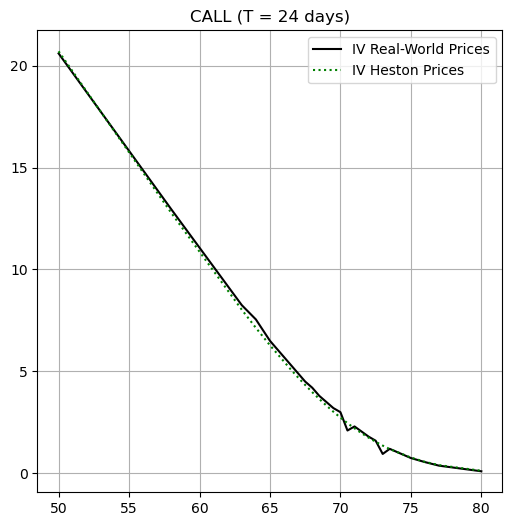

<Figure size 7680x5760 with 0 Axes>

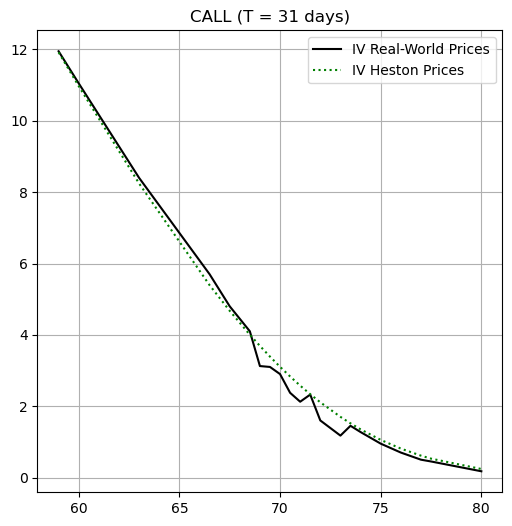

<Figure size 7680x5760 with 0 Axes>

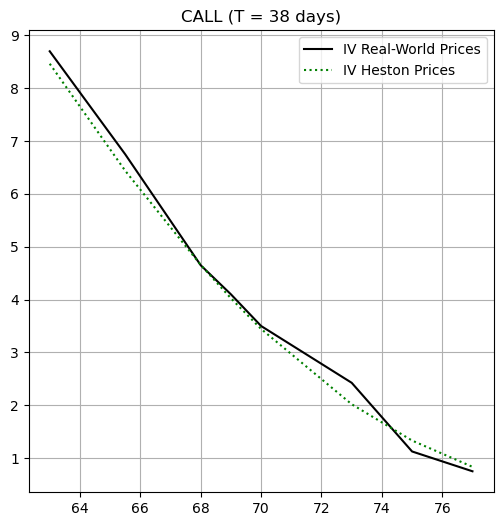

<Figure size 7680x5760 with 0 Axes>

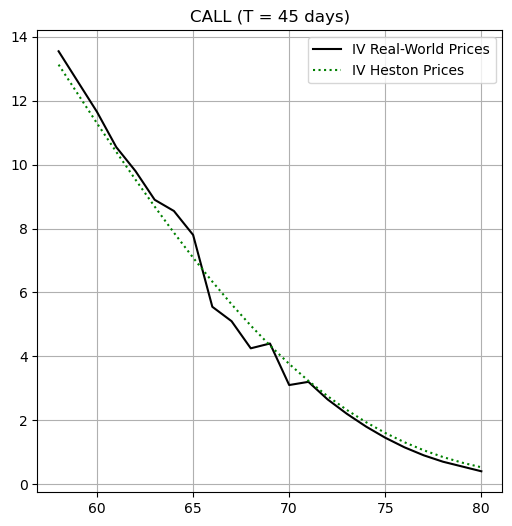

<Figure size 7680x5760 with 0 Axes>

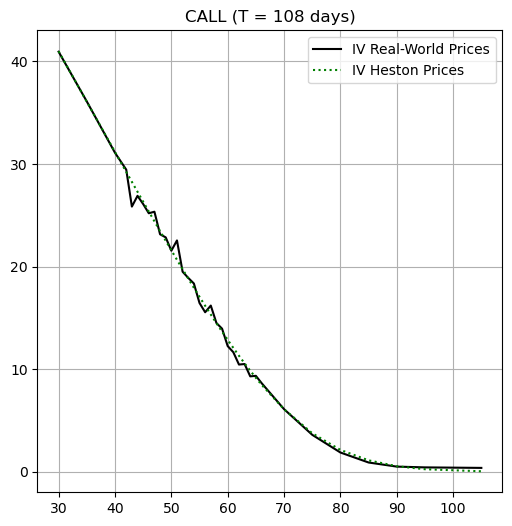

<Figure size 7680x5760 with 0 Axes>

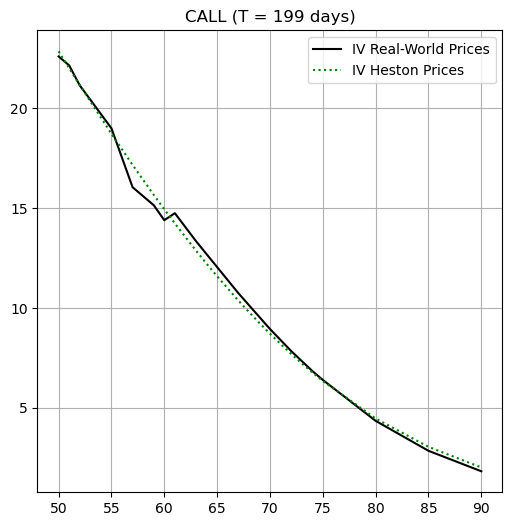

<Figure size 7680x5760 with 0 Axes>

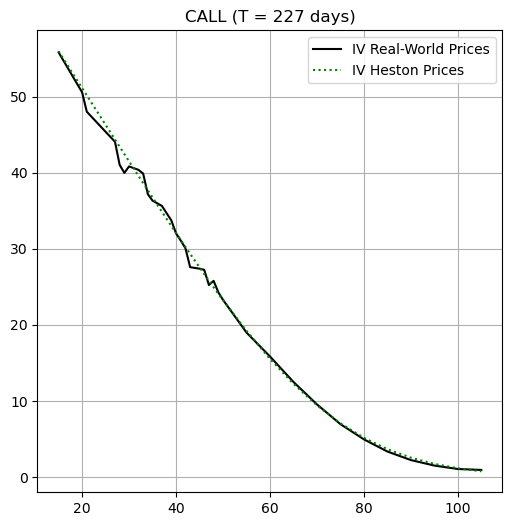

<Figure size 7680x5760 with 0 Axes>

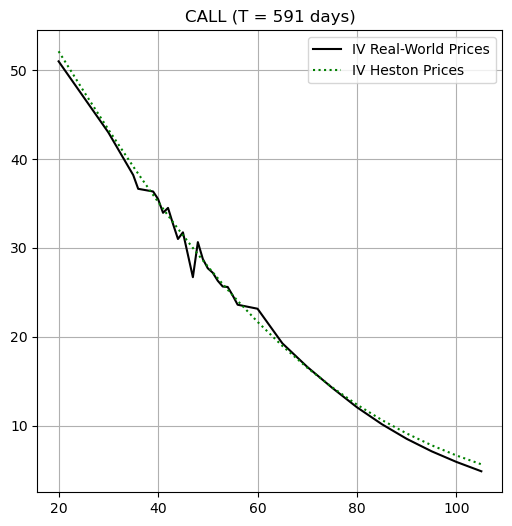

In [1035]:
tau.sort()
print(len(tau))
c=0
while c <len(tau):
  plt.figure(dpi = 1200)
  plt.figure(figsize=(6,6))
  volSurfaceLong1= volSurfaceLong.loc[volSurfaceLong['maturity'] == tau[c]]
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.price, color='black')
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.heston_priceAcc, color='green',linestyle="dotted")
  plt.legend(['IV Real-World Prices', 'IV Heston Prices'], loc='upper right')
  plt.grid()
  plt.title("CALL (T = "+str(math.ceil(tau[c]*365.25))+" days)")
  plt.show()
  c = c + 1


<Figure size 7680x5760 with 0 Axes>

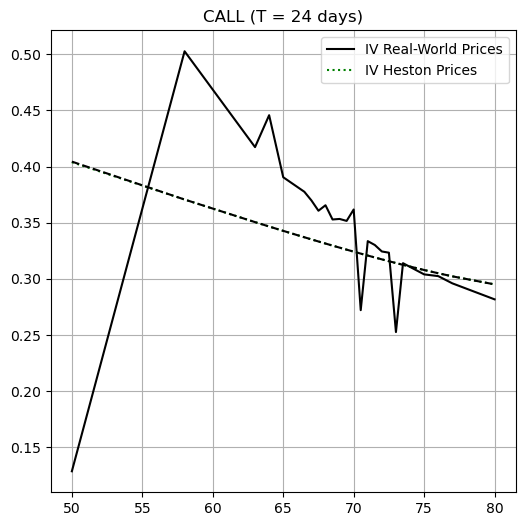

<Figure size 7680x5760 with 0 Axes>

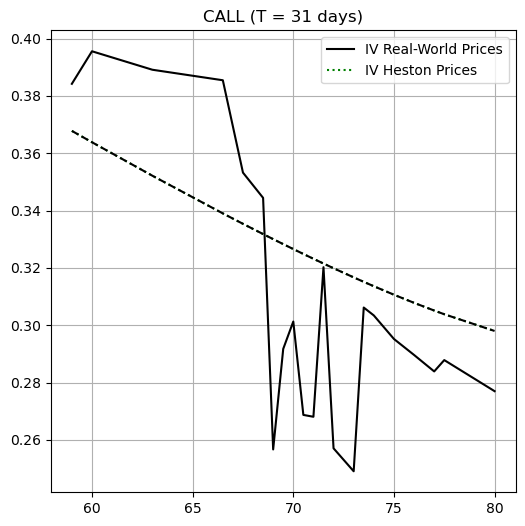

<Figure size 7680x5760 with 0 Axes>

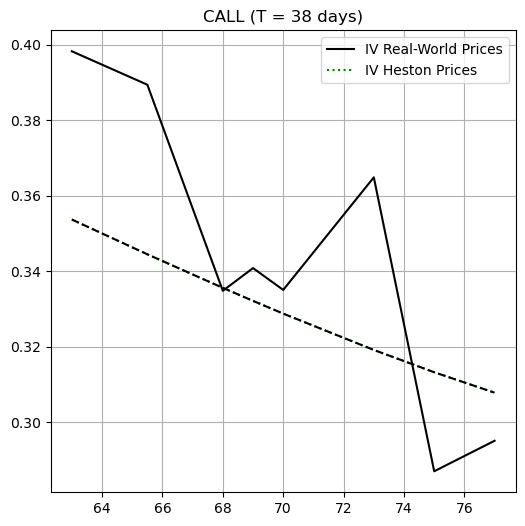

<Figure size 7680x5760 with 0 Axes>

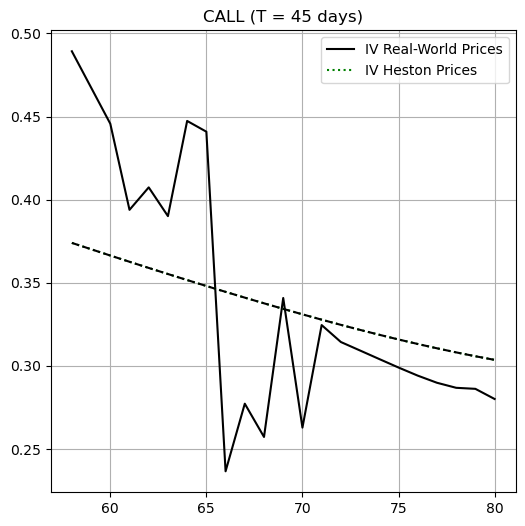

<Figure size 7680x5760 with 0 Axes>

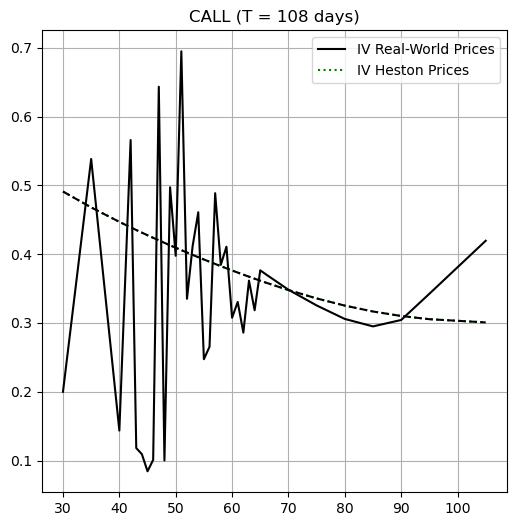

<Figure size 7680x5760 with 0 Axes>

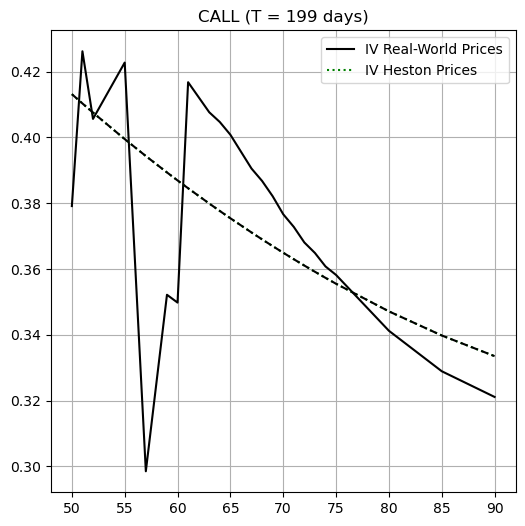

<Figure size 7680x5760 with 0 Axes>

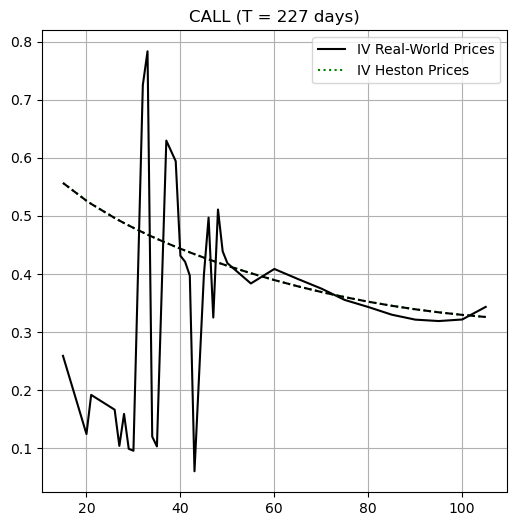

<Figure size 7680x5760 with 0 Axes>

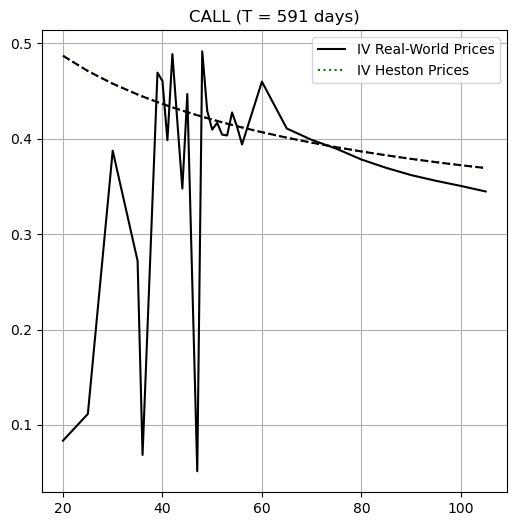

In [1036]:
c=0
tau = volSurfaceLong['maturity']
tau = list(set(tau))
tau.sort()
while c <len(tau):
  plt.figure(dpi = 1200)
  plt.figure(figsize=(6,6))
  volSurfaceLong1= volSurfaceLong.loc[volSurfaceLong['maturity'] == tau[c]]
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.IV, color='black')
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.IVCal, color='green',linestyle="dotted")
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.IVH, color='black',linestyle="dashed")
  plt.legend(['IV Real-World Prices', 'IV Heston Prices'], loc='upper right')
  plt.grid()
  plt.title("CALL (T = "+str(math.ceil(tau[c]*365.25))+" days)")
  plt.show()
  c = c + 1

C:\Users\elepi\AppData\Local\Temp\ipykernel_44836\2493189879.py:100: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

C:\Users\elepi\AppData\Local\Temp\ipykernel_44836\2493189879.py:101: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.

     maturity  strike    price volume      rate        IV   Weights     IVCal  \
0    0.073922   375.0   153.67      2  0.053219  0.132024  0.106542  0.679123   
1    0.131417   375.0   153.95    1.0  0.052960  0.119082  0.053368  0.472657   
2    0.164271   375.0  156.905    4.0  0.052816  0.485627  0.217571  0.402757   
3    0.208077   375.0   155.85    6.0  0.052627  0.068568  0.324162  0.338735   
4    0.246407   375.0   156.87    2.0  0.052465  0.097794  0.108761  0.302574   
..        ...     ...      ...    ...       ...       ...       ...       ...   
667  0.829569   610.0     3.89    5.0  0.050362  0.106264  0.006743  0.118097   
668  1.051335   610.0    7.515   14.0  0.049717  0.112393  0.036472  0.121551   
669  1.549624   610.0    17.53    3.0  0.048514  0.122807  0.018231  0.127634   
670  1.626283   610.0   18.885   10.0  0.048355  0.122932  0.065467  0.128350   
671  2.546201   610.0    38.34      3  0.046887  0.132533  0.039873  0.134077   

          IVH  heston_price

<Figure size 7680x5760 with 0 Axes>

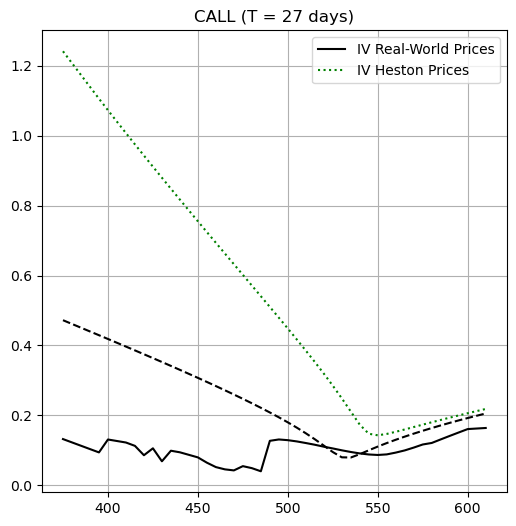

<Figure size 7680x5760 with 0 Axes>

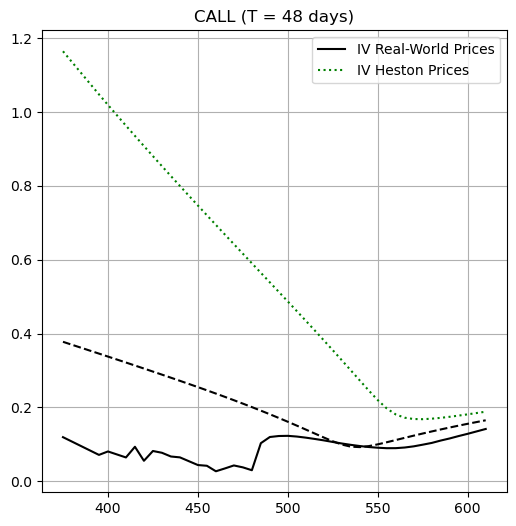

<Figure size 7680x5760 with 0 Axes>

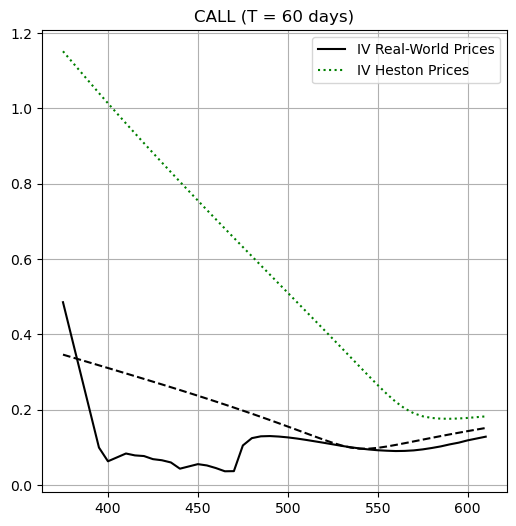

<Figure size 7680x5760 with 0 Axes>

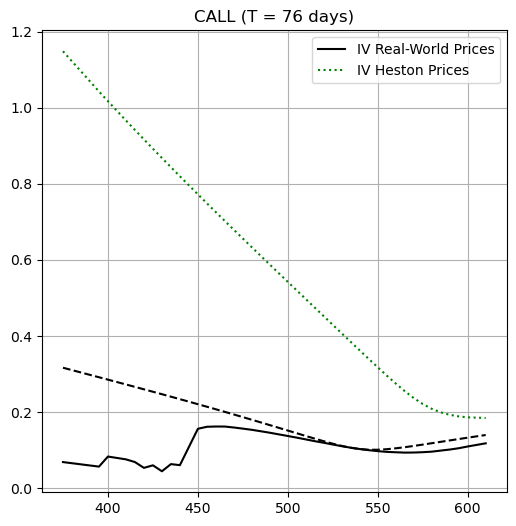

<Figure size 7680x5760 with 0 Axes>

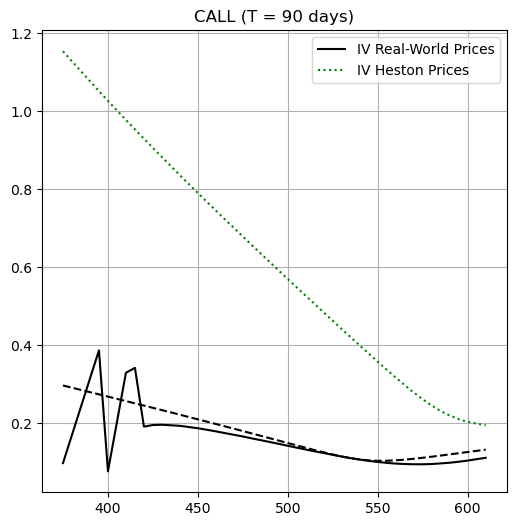

<Figure size 7680x5760 with 0 Axes>

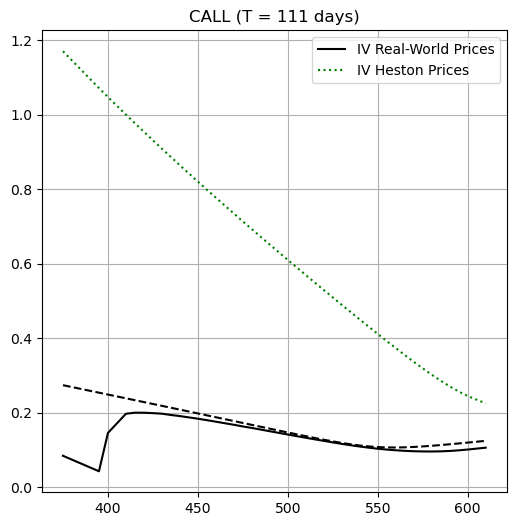

<Figure size 7680x5760 with 0 Axes>

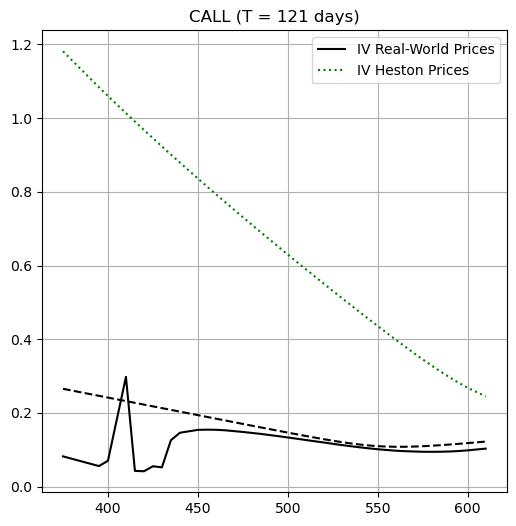

<Figure size 7680x5760 with 0 Axes>

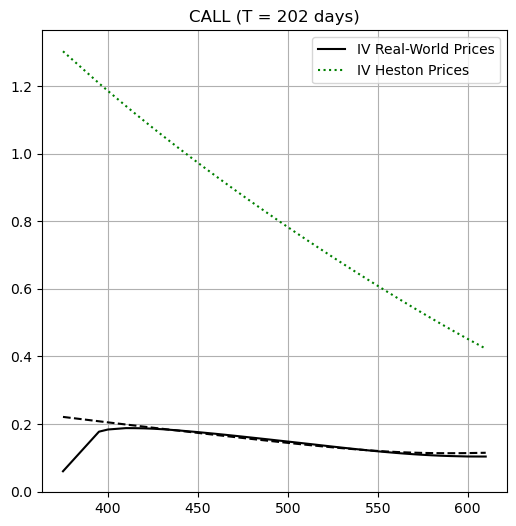

<Figure size 7680x5760 with 0 Axes>

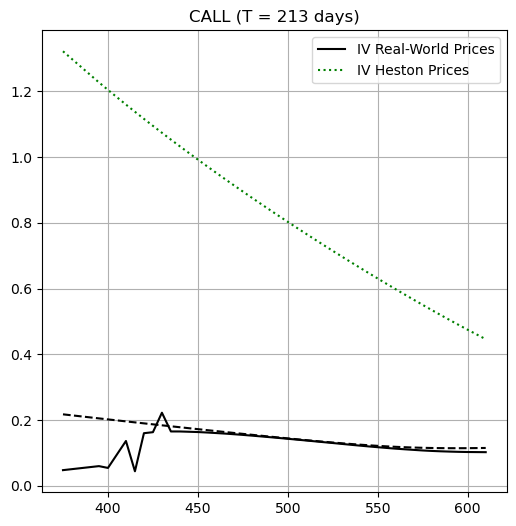

<Figure size 7680x5760 with 0 Axes>

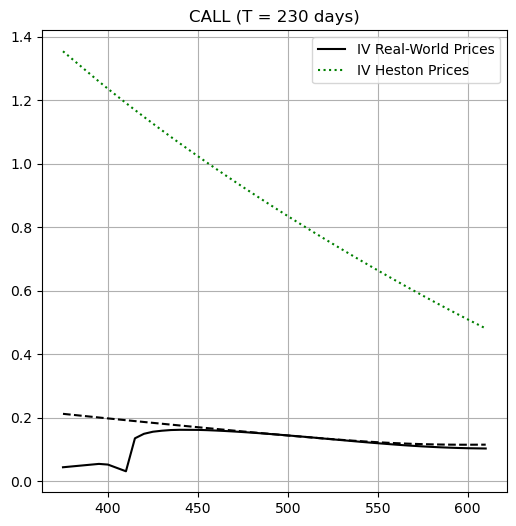

<Figure size 7680x5760 with 0 Axes>

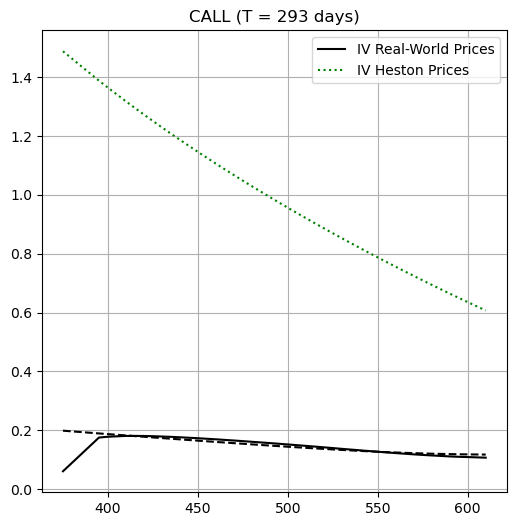

<Figure size 7680x5760 with 0 Axes>

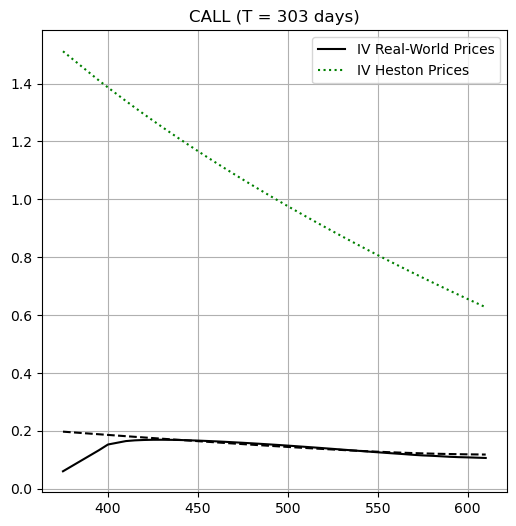

<Figure size 7680x5760 with 0 Axes>

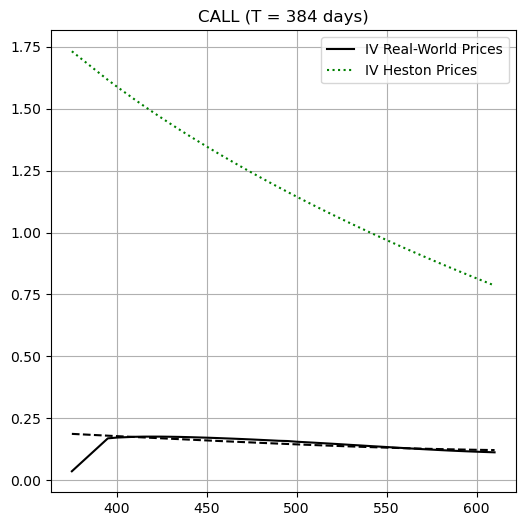

<Figure size 7680x5760 with 0 Axes>

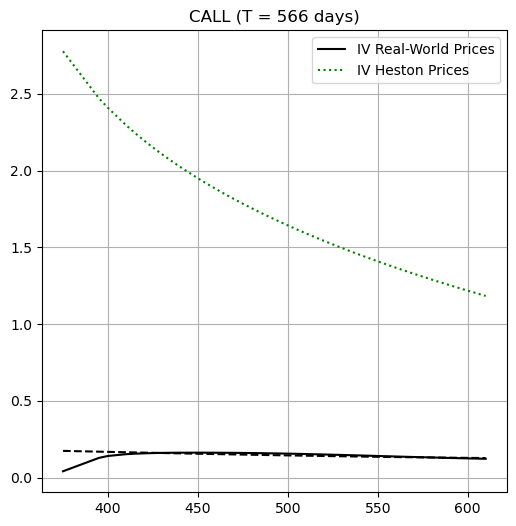

<Figure size 7680x5760 with 0 Axes>

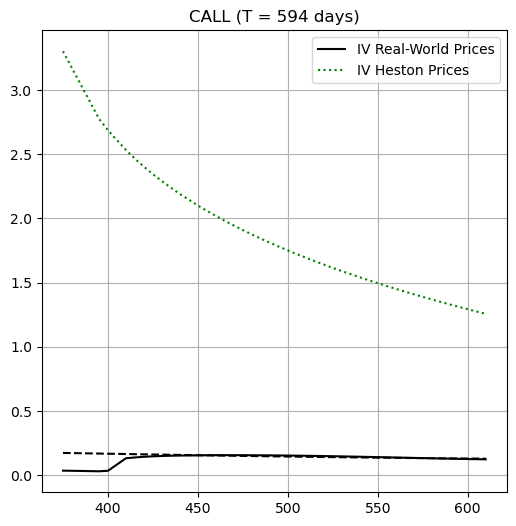

<Figure size 7680x5760 with 0 Axes>

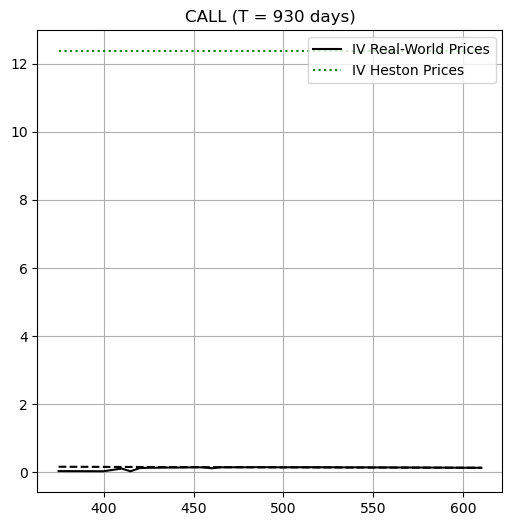

In [845]:
heston3 = []
iv3 = []
c=0
while c <len(volSurfaceLong):
            heston3.append(call_heston_cfsingle1(S0,volSurfaceLong['strike'][c], volSurfaceLong['maturity'][c], volSurfaceLong['rate'][c],-0.3, v0, theta, rho, kappa, sigma, lambd))
            iv3.append(implied_vol(heston3[c], S0, volSurfaceLong['strike'][c], volSurfaceLong['maturity'][c], volSurfaceLong['rate'][c]))
            c = c+1
volSurfaceLong['heston_price3'] = heston3
volSurfaceLong['IV3'] = iv3
print(volSurfaceLong)
c=0
tau = volSurfaceLong['maturity']
tau = list(set(tau))
tau.sort()
while c <len(tau):
  plt.figure(dpi = 1200)
  plt.figure(figsize=(6,6))
  volSurfaceLong1= volSurfaceLong.loc[volSurfaceLong['maturity'] == tau[c]]
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.IV, color='black')
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.IV3, color='green',linestyle="dotted")
  plt.plot(volSurfaceLong1.strike, volSurfaceLong1.IVH, color='black',linestyle="dashed")
  plt.legend(['IV Real-World Prices', 'IV Heston Prices'], loc='upper right')
  plt.grid()
  plt.title("CALL (T = "+str(math.ceil(tau[c]*365.25))+" days)")
  plt.show()
  c = c + 1